# Characterizing edges

The goal of this notebook is to characterize edges of the UMAP graph with respect with their position (internal/external) in the groundtruth partition. It is also to see if the edges misclassified by Leiden/HDBSCAN partitions have particularities (with their endpoints' rho and sigma values, with the number of supporting triangles, etc.) 

For each point $x_i$ in original space, consider $\{x_{i_1}, \cdots, x_{i_k}\}$ the $k$ the set of $k$ nearest neighbors. Then $\rho_i$ is the distance between $x_i$ and its closest (distinct) neighbour. The value $\sigma_i$ is set so that $\sum_{j=1}^k \exp(\frac{-\max(0, d(x_i, x_{i_j}) - \rho_i)}{\sigma_i}) = \log_2(k)$ for every data point $x_i$. If the distances to neighbors are all concentrated, $\sigma$-value will be larger.

The edge values we consider are: 
* high dimensional distance between the edge's endpoints
* UMAP weight
* Sum of endpoints' $\rho$ and $\sigma$ values - as described above
* Number of triangles in the graph containing this specific edge

In [1]:
!git branch

* main


In [2]:
execfile('functions/data_specifics.py')
execfile('functions/graph_functions.py')
print(data_set_list)

['pendigits', 'coil', 'mnist', 'usps', 'buildings', 'clusterable']


In [3]:
from IPython.display import display, Markdown, Latex
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import hdbscan
import umap
from sklearn.neighbors import KNeighborsTransformer
import pynndescent
from scipy.spatial.distance import euclidean

import cdlib.algorithms as cd
import itertools
import collections
import igraph as ig
import leidenalg as la

from community import community_louvain

sns.set()

Note: to be able to use all crisp methods, you need to install some additional packages:  {'karateclub', 'infomap', 'graph_tool', 'wurlitzer'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


# Functions

In [125]:
def enrich_graph_edge_properties(G, vertex_high_representation=None):
    
    G.es['umap_weight'] = G.es['weight']
    
    simplices = G.cliques(min=3, max=3)
    edge_in_simplex = []
    for x in simplices:
        edge_in_simplex += G.get_eids([pair for pair in itertools.combinations(x, r=2)])
    G.es["nb_triangles"] = 0
    for k, v in collections.Counter(edge_in_simplex).items():
        G.es[k]["nb_triangles"] = v
    
    for e in G.es:
        e['sigma_sum'] = sum([G.vs[e.target]['sigmas'],G.vs[e.source]['sigmas']])
        e['rho_sum'] = sum([G.vs[e.target]['rhos'],G.vs[e.source]['rhos']])
        
    if(vertex_high_representation is not None):
        G.es['highdim_dist'] = [euclidean( vertex_high_representation[e.source], 
                                         vertex_high_representation[e.target] ) 
                               for e in G.es]  
        for v in G.vs:
            x = {e:G.es[e]['highdim_dist'] for e in G.incident(v)}
            for i,e in enumerate(sorted(x, key=x.get)):
                G.es[e]['highdim_rank'] = i
    return(G)

In [5]:
# Plotting the features using boxes
def barPlot_split_on(what, split_on, edge_df, nb_cols=3):
    print(collections.Counter(edge_df[split_on]))
    nb_rows = int(np.ceil(len(what)/nb_cols))
    plt.style.use('ggplot')
    fig, axes = plt.subplots(nb_rows, nb_cols, figsize=(15, 4*nb_rows))
    for i, var in enumerate(what):
        w_row = (i//nb_cols)
        w_col = (i%nb_cols)
        plt.subplot(nb_rows, nb_cols, i+1)
        sns.boxplot(x = split_on, y = var, data = edge_df)
        axes[w_row][w_col].title.set_text(var)
        if(w_row < nb_rows-1):
            plt.xlabel('')
        plt.ylabel('')

# Pendigits clustering scores

Conclusion from empirical study. Standard graph clustering algorithms tend to produce a larger number of parts than HDBSCAN on lower dimensional, and than ground truth. 

In [139]:
def get_edge_concatures(dataset_id):
    raw_data, targets, dataset_name = get_dataset(dataset_id)
    G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=0)
    G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')
    
    G = enrich_graph_edge_properties(G, 
                                 vertex_high_representation=raw_data)
    edge_df = G.get_edge_dataframe()
    eps = 0.001 
    edge_df['log_rank'] = np.log(edge_df.pop('highdim_rank')+eps)
    edge_df['log_sigma'] = np.log(edge_df.pop('sigma_sum')+eps)
    edge_df['log_rho'] = np.log(edge_df.pop('rho_sum')+eps)
    edge_df['log_triangles'] = np.log(edge_df.pop('nb_triangles')+eps)
    edge_df['dataset_id'] = dataset_id
    edge_df.pop('weight')
    return(edge_df)

In [140]:
edge_features = [get_edge_features(i) for i in range(5)]

In [141]:
edge_df = pd.concat(edge_features)
edge_df.shape

(124291, 9)

In [142]:
edge_df.head(3)

,source,target,internal,umap_weight,highdim_dist,log_rank,log_sigma,log_rho,log_triangles
edge ID,,,,,,,,,
0,0,335,True,0.011834,16.370705,1.791926,1.303508,3.202488,1.098946
1,0,464,True,0.147699,13.453624,1.098946,1.299944,3.149516,1.386544
2,0,676,True,0.010062,17.349352,1.609638,1.441225,3.209864,0.693647


In [143]:
X = edge_df[['log_triangles', 'log_sigma', 'log_rho', 'log_rank', 'umap_weight']].to_numpy()
y = edge_df.internal.to_numpy()
X.shape

(124291, 5)

In [144]:
edge_df[['internal']].value_counts()

internal
True        121909
False         2382
dtype: int64

In [145]:
X_mapper = umap.UMAP().fit(X)

In [146]:
import umap.plot

In [147]:
X_2d = X_mapper.embedding_

<AxesSubplot:>

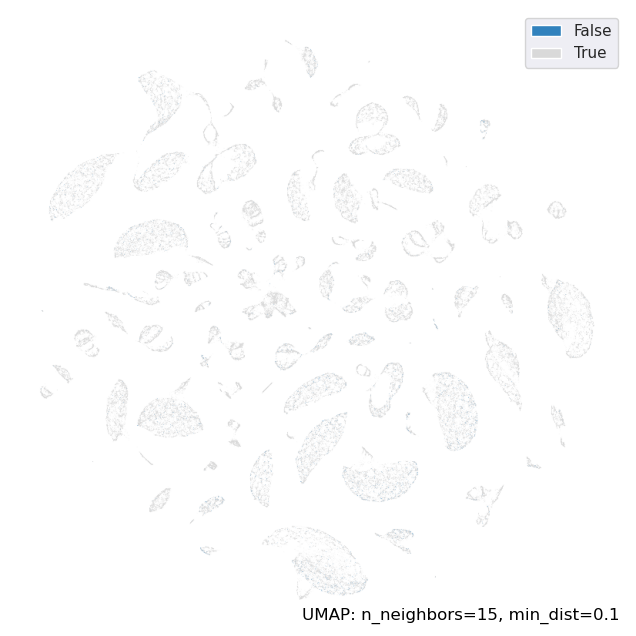

In [148]:
umap.plot.points(X_mapper, labels=edge_df.internal, theme='green')

In [149]:
umap.plot.points(X_mapper, labels=edge_df.dataset_id)

AttributeError: 'DataFrame' object has no attribute 'dataset_id'

## Decision Tree

In [69]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from numpy import mean

In [57]:
model = DecisionTreeClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.655


# Class Imbalance Problem

From: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

## Grid search for imbalanced datasets

In [55]:
# define grid
balance = [{0:5,1:100}, {0:10,1:100}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
param_grid = dict(class_weight=balance)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X, y)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.661933 using {'class_weight': {0: 5, 1: 100}}
0.661933 (0.021797) with: {'class_weight': {0: 5, 1: 100}}
0.661896 (0.020569) with: {'class_weight': {0: 10, 1: 100}}
0.653293 (0.024991) with: {'class_weight': {0: 1, 1: 1}}
0.661319 (0.022703) with: {'class_weight': {0: 1, 1: 10}}
0.660981 (0.019130) with: {'class_weight': {0: 1, 1: 100}}


## SMOTE

In [64]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from matplotlib import pyplot
from numpy import where

Counter({True: 16136, False: 983})
Counter({True: 16136, False: 16136})


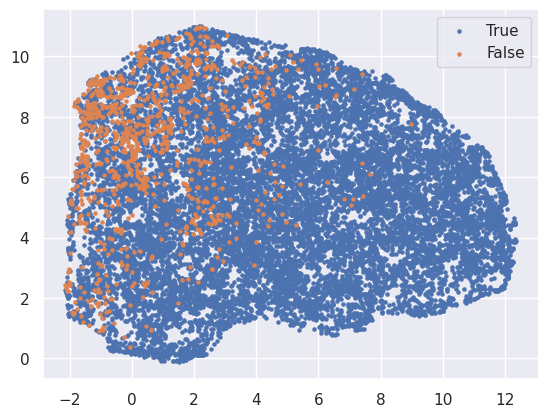

In [62]:
# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SMOTE()
X_resample, y_resample = oversample.fit_resample(X_2d, y)
# summarize the new class distribution
counter = Counter(y_resample)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X_resample[row_ix, 0], X_resample[row_ix, 1], label=str(label), s=5)
pyplot.legend()
pyplot.show()

In [80]:
# define pipeline
model = DecisionTreeClassifier()
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.757


### In SMOTE, there is a value fixed for the number of nearest neighbors to use. We could Grid Search over a range of values

In [77]:
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
    # define pipeline
    model = DecisionTreeClassifier()
    over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = mean(scores)
    print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=1, Mean ROC AUC: 0.745
> k=2, Mean ROC AUC: 0.754
> k=3, Mean ROC AUC: 0.755
> k=4, Mean ROC AUC: 0.752
> k=5, Mean ROC AUC: 0.752
> k=6, Mean ROC AUC: 0.758
> k=7, Mean ROC AUC: 0.752


## Borderline-SMOTE

Counter({True: 16136, False: 983})
Counter({True: 16136, False: 16136})


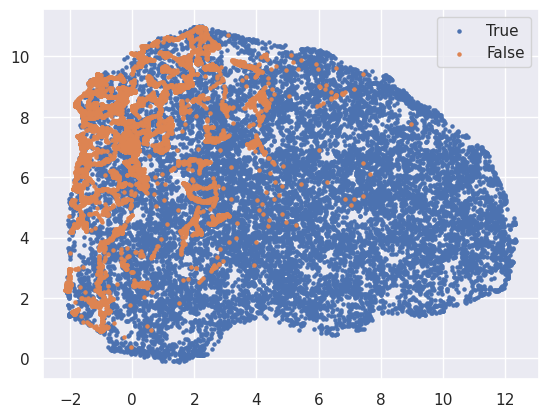

In [83]:
# borderline-SMOTE with SVM for imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SVMSMOTE
from matplotlib import pyplot
from numpy import where
# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SVMSMOTE()
X_over, y_over = oversample.fit_resample(X_2d, y)
# summarize the new class distribution
counter = Counter(y_over)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y_over == label)[0]
    pyplot.scatter(X_over[row_ix, 0], X_over[row_ix, 1], label=str(label), s=5)
pyplot.legend()
pyplot.show()

In [87]:
# define pipeline
model = DecisionTreeClassifier(max_depth=3)
over = SVMSMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.881


In [ ]:
X_train
pipe = pipeline.fit(X_train, y_train)